In [1]:
#r "nuget: BenchmarkDotNet, 0.13.9"
#r "nuget: Microsoft.Playwright, 1.39.0"
#r "nuget: NUlid, 1.7.1"
#r "nuget: NAudio, 2.2.1"
#r "nuget: SixLabors.ImageSharp, 3.0.2"
#r "nuget: SixLabors.ImageSharp.Drawing, 2.0.0"
#r "nuget: SixLabors.Fonts, 2.0.0"
#r "bin/Release/net6.0/ConsoleBenchmark.dll"

Installed Packages BenchmarkDotNet, 0.13.9 Microsoft.Playwright, 1.39.0 NAudio, 2.2.1 NUlid, 1.7.1 SixLabors.Fonts, 2.0.0 SixLabors.ImageSharp, 3.0.2 SixLabors.ImageSharp.Drawing, 2.0.0

In [2]:
NUlid.Ulid newUlid = NUlid.Ulid.NewUlid();
Console.WriteLine(newUlid);

int sampleRate = 44100;
int seconds = 2;
NAudio.Wave.WaveFormat waveFormat = new NAudio.Wave.WaveFormat(sampleRate, 1); // Mono sound
var samples = new List<float>();

for (int n = 0; n < sampleRate * seconds; n++)
{
    float sampleValue = 0;
    for (int i = 0; i < newUlid.ToString().Length; i++)
    {
        char c = newUlid.ToString()[i];
        int value = (int)c;

        // Create a simple sinusoidal waveform based on the ULID
        sampleValue += (float)Math.Sin((2 * Math.PI * value * n) / sampleRate);
    }

    samples.Add(sampleValue);
}

var waveProvider = new NAudio.Wave.BufferedWaveProvider(waveFormat);
waveProvider.AddSamples(samples.SelectMany(v => BitConverter.GetBytes(v)).ToArray(), 0, samples.Count * 4); // 4 bytes per float

// Use a MemoryStream to write the WAV data and then base64 encode it
using (var memoryStream = new System.IO.MemoryStream())
{
    using (var waveFileWriter = new NAudio.Wave.WaveFileWriter(memoryStream, waveFormat))
    {
        byte[] bytes = new byte[waveProvider.BufferLength];
        waveProvider.Read(bytes, 0, waveProvider.BufferLength);
        waveFileWriter.Write(bytes, 0, bytes.Length);
    }

    byte[] audioData = memoryStream.ToArray();
    string base64Audio = Convert.ToBase64String(audioData);
    
    // Display the audio element with the base64 encoded data
    var audioTag = Microsoft.DotNet.Interactive.Formatting.PocketViewTags.video[controls: true, src: $"data:audio/wav;base64,{base64Audio}"]();
    display(audioTag);
}


01HDE67W8KWB6DZH09NCHGDCD7


<video controls="True" src="data:audio/wav;base64,UklGRs66BgBXQVZFZm10IBIAAAABAAEARKwAAIhYAQACABAAAABkYXRhqLoGAAAAAADrFHs+yhH7Pm9JPD9MBXs/c92cP1k0vD+Shts/VNP6P+sMDUCrrBxAgkgsQBHgO0DycktAyABbQCeJakCzC3pAAcSEQNx+jEA5NpRA5embQLKZo0BtRatA5uyyQOyPukBMLsJA3MfJQGVc0UC869hArXXgQA3650CmeO9ATfH2QNBj/kAE6AJB3JoGQV5KCkFx9g1B/J4RQexDFUEn5RhBmIIcQSQcIEG3sSNBPUMnQZ7QKkG/WS5Bjd4xQfheNUHe2jhBNFI8QeDEP0HHMkNB3ptGQQcASkEwX01BRrlQQS4OVEHbXVdBMqhaQSPtXUGWLGFBeGZkQbaaZ0E8yWpB9fFtQc4UcUGzMXRBk0h3QVdZekHvY31BIzSAQSezgUH4LoNBjaeEQd8chkHijodBjv2IQd1oikHE0ItBOTWNQTiWjkGy849Bpk2RQQikkkHQ9pNB9EWVQXORlkE82ZdBTx2ZQaBdmkEqmptB4tKcQcQHnkHIOJ9B52WgQRyPoUFatKJBodWjQefypEElDKZBViGnQXQyqEF6P6lBW0iqQRlNq0GuTaxBDUqtQTVCrkEiNq9BzCWwQS0RsUFD+LFBCduyQXW5s0GHk7RBOmm1QYU6tkFqB7dB3c+3QeKTuEFwU7lBgQ66QRnFukErd7tBuiS8QcDNvEE6cr1BIhK+QXutvkE7RL9BZda/QfFjwEHe7MBBLXHBQdnwwUHea8JBP+LCQfNTw0H8wMNBVynEQQaNxEEC7MRBTUbFQeSbxUHK7MVB9jjGQW+AxkEuw8ZBOQHHQYc6x0Eib8dBAZ/HQSXKx0GT8MdBSBLIQUAvyEGCR8hBDFvIQd5pyEH6c8hBXnnIQQ96yEEJdshBU23IQexfyEHVTchBDDfIQZkbyEF6+8dBstbHQUOtx0Eyf8dBekzHQSAVx0Ev2cZBnpjGQXZTxkG7CcZBbbvFQY1oxUEiEcVBLbXEQblUxEG978NBRYbDQVMYw0HqpcJBEC/CQcmzwUEaNMFBAbDAQYgnwEG1mr9BiQm/QQp0vkFB2r1BLDy9QdSZvEE+87tBcEi7QW6ZukE85rlB4y65QWlzuEHSs7dBJfC2QWgotkGeXLVB0Iy0QQa5s0FG4bJBkwWyQfolsUF5QrBBH1uvQe5vrkHzgK1BLo6sQaeXq0FrnapBfJ+pQeSdqEGrmKdB1I+mQW6DpUF9c6RBCGCjQRtJokG4LqFB6xCgQb3vnkE2y51BXKOcQTl4m0HXSZpBPRiZQXPjl0GFq5ZBdnCVQVQylEEn8ZJB+ayRQdBlkEG5G49Buc6NQdx+jEEsLItBsNaJQXR+iEGAI4dB4MWFQZtlhEG6AoNBSp2BQVI1gEG/lX1B8bt6QVLdd0H3+XRB8BFyQVclb0E6NGxBsD5pQdREZkGzRmNBYkRgQfw9XUGPM1pBMiVXQfoSVEED/VBBV+NNQRLGSkFIpUdBDYFEQXdZQUGeLj5BlwA7QXTPN0FOmzRBNWQxQUoqLkGX7SpBO64nQUdsJEHSJyFB8OAdQbmXGkFDTBdBpf4TQfSuEEFEXQ1BrAkKQUW0BkEkXQNBXAQAQQdU+UBtnPJACeLrQA8l5UChZd5A+6PXQD/g0ECbGspAPFPDQEyKvED3v7VAbPSuQNgnqEBgWqFAOIyaQIe9k0B67oxAPh+GQPaffkDAAXFALmRjQKDHVUBZLEhAw5I6QCz7LEDqZR9AVNMRQLxDBED6bu0/0F3SP6hUtz8rVJw//lyBP5vfTD9+Ghc/6tfCPjRVLz4Agxq94Cx8vgul6L7HfCm/wIhev5a6ib9dIKS/HnW+vzC42L/86PK/a4MGwJyIE8C1gyDAcnQtwIJaOsCUNUfAXwVUwJjJYMDxgW3AIi56wOtmg8BpsInAYPOPwK4vlsAuZZzAuZOiwDC7qMBt267ATfS0wKwFu8BoD8HAXBHHwGgLzcBr/dLAP+fYwMjI3sDioeTAbHLqwEU68MBM+fXAY6/7wDauAMEjgAPBZ00GwfUVCcG82QvBr5gOwb5SEcHbBxTB9rcWwf9iGcHuCBzBsKkewTZFIcF42yPBYWwmwer3KMEDfivBnv4twbB5MMEr7zLBA181wS7JN8GdLTrBRIw8wRblPsEIOEHBFoVDwSvMRcFADUjBRkhKwTt9TMEMrE7BtdRQwSj3UsFbE1XBRilXwd44WcEbQlvB9URdwV9BX8FSN2HBxyZjwbMPZcEQ8mbB2M1owf6iasF6cWzBTTluwWf6b8HDtHHBXGhzwS0VdcEqu3bBUlp4wZryecEEhHvBgA59wRCSfsFWB4DBKsKAwXx5gcFPLYLBn92CwWmKg8GsM4TBZtmEwZR7hcE1GobBSbWGwc1Mh8G+4IfBHXGIwen9iMEfh4nBwAyKwcmOisE5DYvBEoiLwVD/i8H1cozB/+KMwXFPjcFGuI3Bgh2OwSB/jsEk3Y7BjTePwVuOj8GP4Y/BKjGQwSx9kMGTxZDBYgqRwZtLkcE9iZHBScORwcX5kcGoLJLB/FuSwb+HksHyr5LBmNSSwbT1ksFFE5PBTC2Twc5Dk8HKVpPBRmaTwUFyk8G+epPBv3+TwUeBk8FZf5PB93mTwSNxk8HhZJPBNFWTwR5Ck8GiK5PBwxGTwYX0ksHr05LB9q+SwbGIksEXXpLBLjCSwfz+kcGCypHByJKRwc1XkcGVGZHBJ9iQwYmTkMG6S5DBwACQwaOyj8FiYY/BAw2PwY21jsEEW47Ba/2NwcecjcEdOY3BddKMwc9ojME0/IvBpYyLwSoai8HJpIrBhSyKwWaxicFwM4nBp7KIwRMviMG3qIfBmR+HwcOThsE3BYbB+nOFwRXghMGLSYTBY7CDwaMUg8FQdoLBddWBwRIygcExjIDBq8d/wQ9yfsGcF33BW7h7wV9UesGv63jBW353wXAMdsH4lXTBBBtzwaKbccHaF3DBwI9uwV8DbcHDcmvB/d1pwRlFaMEkqGbBLgdlwUNiY8F0uWHBzAxgwVtcXsEvqFzBVfBawd00WcHVdVfBS7NVwU/tU8HtI1LBNFdQwTSHTsH8s0zBmN1KwRwEScGSJ0fBCEhFwZFlQ8E3gEHBDpg/wSOtPcGDvzvBP885wWbcN8EG5zXBLe8zwe/0McFV+C/BcPktwVP4K8EG9SnBnu8nwSXoJcGu3iPBR9Mhwf7FH8Hkth3BB6YbwXeTGcFAfxfBdmkVwSJSE8FYORHBJR8PwZkDDcHB5grBrcgIwW2pBsEPiQTBnmcCwTJFAMGkQ/zAIPv3wPGw88A6Ze/AERjrwJzJ5sDzeeLAOCnewIDX2cDvhNXAoDHRwK7dzMA1icjAWDTEwCzfv8DQibvAZDS3wP/essDAia7AvzSqwCHgpcD3i6HAZDidwIDlmMBok5TAOEKQwAjyi8D1oofAHFWDwCcRfsDuenXAyudswOVXZMB6y1vAwEJTwNy9SsAVPULAkMA5wIRIMcAi1SjAomYgwC39F8D6mA/AOzoHwDbC/b+kG+2/FIHcv+/yy7+Ccbu/Rv2qv4SWmr+aPYq/1uVzv5VtU785EzO/aNcSv5F15b5GfKW+TIhLvvg5mb3AGEc9MJ8vPop1lj6609Q+YHQJP7NZKD9DGUc/XbJlPzQSgj9lN5E/fEigPyRFrz8OLb4//v/MP5y92z+qZeo/3ff4P/W5A0DL7ApASBQSQEowGUC4QCBAZ0UnQDs+LkATKzVA0ws8QFbgQkCAqElAMGRQQE4TV0C6tV1AU0tkQALUakCrT3FAML53QHoffkCyOYJA8lyFQGp5iEARj4tA2Z2OQLalkUCdppRAgqCXQFqTmkAZf51At2OgQCVBo0BeF6ZAVOaoQP+tq0BVbq5ASiexQNvYs0D7grZAniW5QM

In [3]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (ConsoleBenchmark.PlaywrightFixture fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var jsonElement = await fixture.Expression1JsonElementEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.Expression1JsonElementEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression1JsonElementEvaluateAsync: 16ms


In [4]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var gameState = await fixture.Expression2StringDeserializeEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.Expression2StringDeserializeEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression2StringDeserializeEvaluateAsync: 10ms



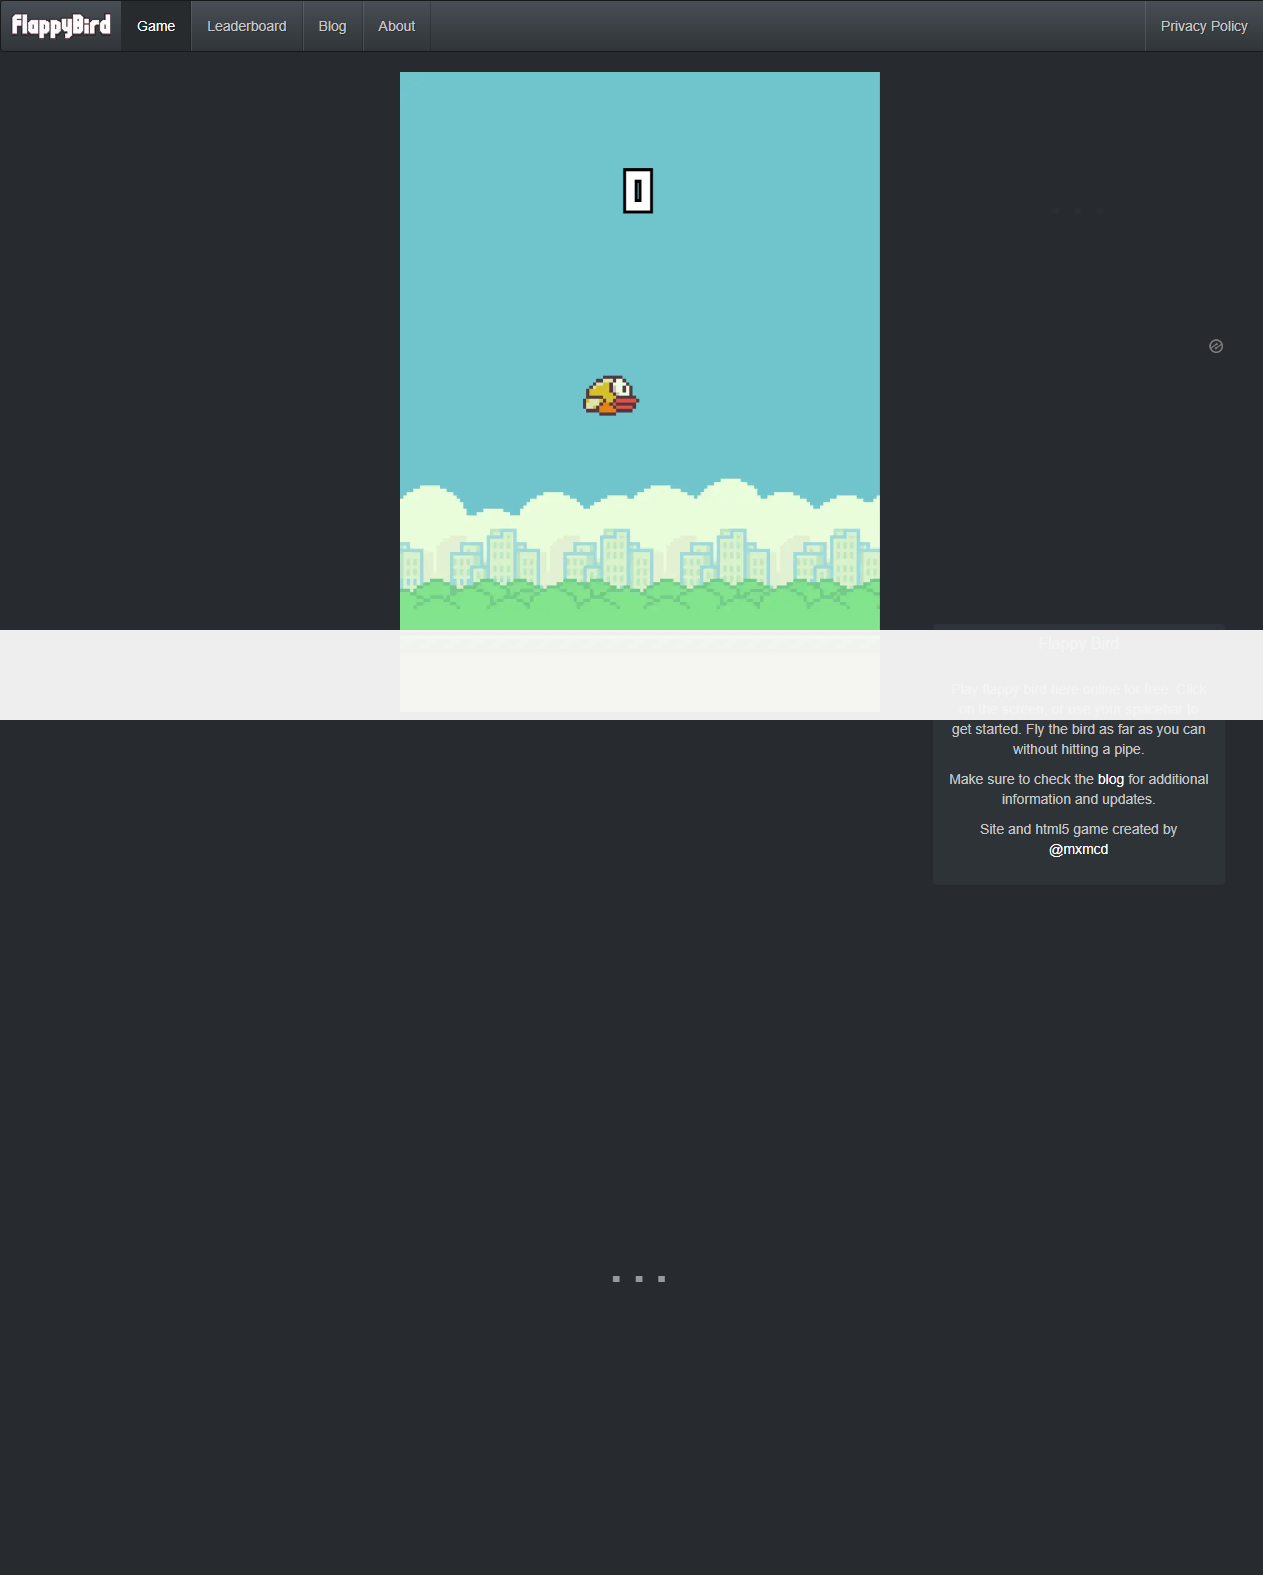

ScreenshotBytesAsync: 229ms


In [5]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.ScreenshotBytesAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.ScreenshotBytesAsync)}: {stopWatch.ElapsedMilliseconds}ms");


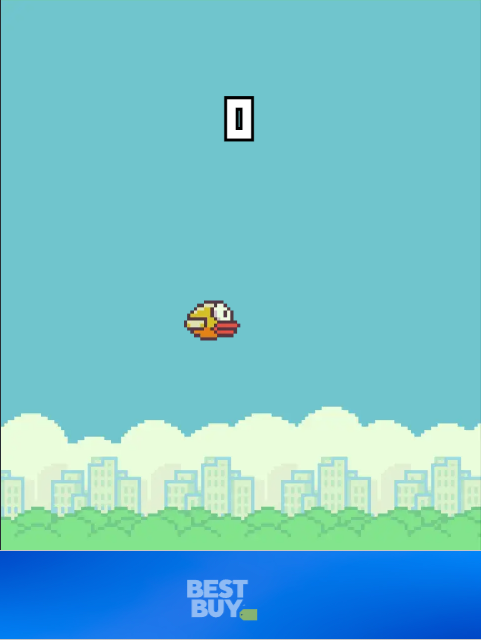

QuerySelectorAsyncScreenshotAsync: 436ms


In [6]:
var stopWatch = new System.Diagnostics.Stopwatch();

await using (var fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.QuerySelectorAsyncScreenshotAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.QuerySelectorAsyncScreenshotAsync)}: {stopWatch.ElapsedMilliseconds}ms");

.\bin\Release\net6.0\01HDE68NH8XT85MFWH1Q2CRE41.png


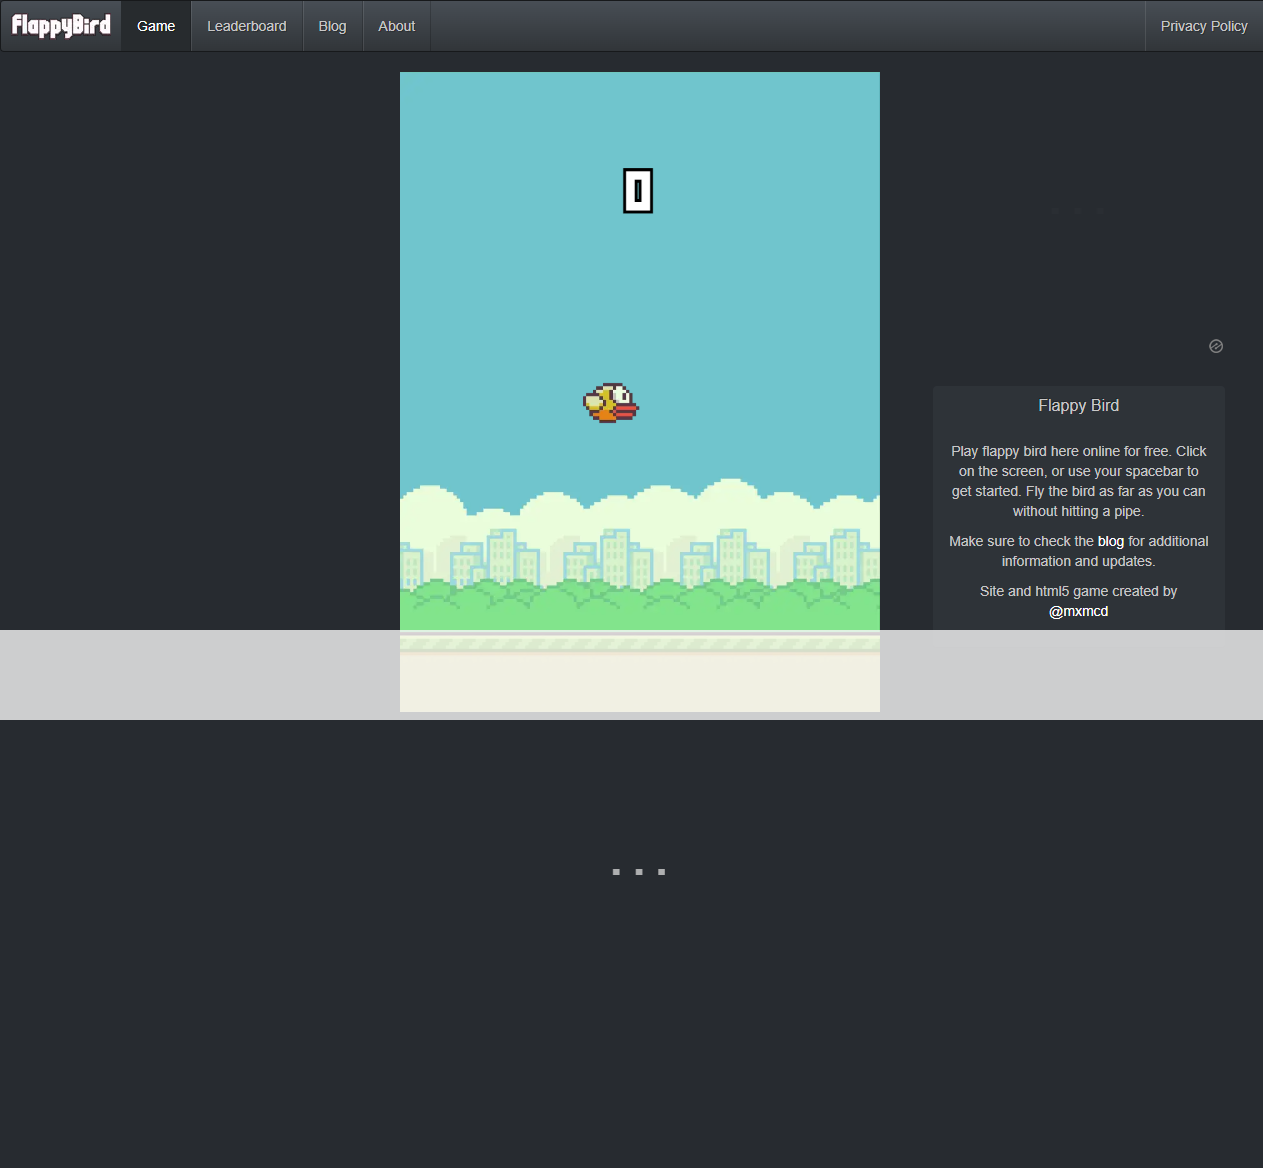

ScreenshotSaveAsync: 221ms


In [7]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var path = await fixture.ScreenshotSaveAsync();
    stopWatch.Stop();
    var screenshotBytes = await System.IO.File.ReadAllBytesAsync(path);
    var base64str = Convert.ToBase64String(screenshotBytes);
    display(path.Replace(System.IO.Directory.GetCurrentDirectory(), "."));
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.ScreenshotSaveAsync)}: {stopWatch.ElapsedMilliseconds}ms");

In [8]:
NUlid.Ulid newUlid = NUlid.Ulid.NewUlid();
Console.WriteLine(newUlid);

01HDE68P0511TSTJWGYDN8D5KZ



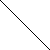


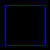

In [9]:
System.Drawing.Bitmap b = new System.Drawing.Bitmap(50, 50);
System.Drawing.Graphics g = System.Drawing.Graphics.FromImage(b);

void d()
{
    using (System.IO.MemoryStream memStream = new System.IO.MemoryStream()) {
        b.Save(memStream, System.Drawing.Imaging.ImageFormat.Png);
        string base64str = Convert.ToBase64String(memStream.ToArray());
        display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
    };
}

g.Clear(System.Drawing.Color.White);
g.DrawLine(System.Drawing.Pens.Black, 0, 0, b.Width, b.Height);
d();

g.Clear(System.Drawing.Color.Black);
g.DrawRectangle(System.Drawing.Pens.Blue, 5, 5, b.Width-10, b.Height-10);
d();

In [10]:
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "https://www.youtube.com/embed/-1pVLJl_snc?si=b72ci--nGXhEGYy8&amp;start=163;", width: 560, height: 315]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "http://www.youtube.com/embed/-1pVLJl_snc?si=b72ci--nGXhEGYy8&amp;start=163;", width: 560, height: 315]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "https://www.youtube.com/embed/-1pVLJl_snc?si=b72ci--nGXhEGYy8&amp;start=163&amp;autoplay=1&amp;loop=1;", width: 560, height: 315]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "http://www.youtube.com/embed/-1pVLJl_snc?si=b72ci--nGXhEGYy8&amp;start=163&amp;autoplay=1&amp;loop=1;", width: 560, height: 315]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "https://looptube.io/?videoId=-1pVLJl_snc&start=165&end=188&rate=1", width: 560, height: 315]);

In [11]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await ConsoleBenchmark.PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var path = await fixture.ScreenshotSaveAsync();
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: path.Replace(System.IO.Directory.GetCurrentDirectory(), ".")]);
}
Console.WriteLine($"{nameof(ConsoleBenchmark.PlaywrightFixture.ScreenshotSaveAsync)}: {stopWatch.ElapsedMilliseconds}ms");

ScreenshotSaveAsync: 228ms


01HDE68SEVTW23G11DGQDAT90D



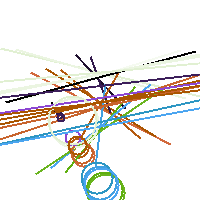

In [12]:
System.Drawing.Bitmap b = new System.Drawing.Bitmap(200, 200);
System.Drawing.Graphics g = System.Drawing.Graphics.FromImage(b);
NUlid.Ulid newUlid = NUlid.Ulid.NewUlid();
Console.WriteLine(newUlid);
// Clear canvas
g.Clear(System.Drawing.Color.White);

// Start drawing based on the ULID
for (int i = 0; i < newUlid.ToString().Length; i++)
{
    char c = newUlid.ToString()[i];
    int value = (int)c;

    // Use value to set color
    System.Drawing.Color color = System.Drawing.Color.FromArgb(value * 10 % 255, value * 5 % 255, value * 15 % 255);
    using System.Drawing.Pen pen = new System.Drawing.Pen(color, 2);

    // Draw some graphics
    g.DrawEllipse(pen, value % b.Width, (value * 2) % b.Height, value % 50, value % 50);
    g.DrawLine(pen, i * 15, value % b.Height, b.Width - i * 15, (value * 2) % b.Height);
}

using (System.IO.MemoryStream memStream = new System.IO.MemoryStream()){
    b.Save(memStream, System.Drawing.Imaging.ImageFormat.Png);
    string base64str = Convert.ToBase64String(memStream.ToArray());
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}


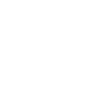

In [13]:
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Drawing.Processing;

// Parameters
int width = 100;
int height = 100;
int numberOfFrames = 10;
int circleDiameter = 20;

// Create individual frames
SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>[] frames = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>[numberOfFrames];

for (int i = 0; i < numberOfFrames; i++)
{
    var image = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);
    int positionX = i * (width - circleDiameter) / (numberOfFrames - 1);

    image.Mutate(ctx => ctx.Fill(SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#333333"))  // Background color
                        .Fill(SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#df3079"), new SixLabors.ImageSharp.Drawing.EllipsePolygon(positionX + circleDiameter / 2, height / 2, circleDiameter / 2)));  // Moving circle
    
    frames[i] = image;
}

// Create the GIF
var outputImage = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);
for (int i = 0; i < numberOfFrames; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    outputImage.Frames[i].Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance).FrameDelay = 100;  // 100ms delay = 10fps
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream()){    
    outputImage.Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new SixLabors.ImageSharp.Formats.Gif.GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}


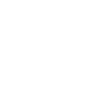

In [14]:
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Drawing.Processing;

// Parameters
int width = 100;
int height = 100;
int numberOfFrames = 26;  // Length of a ULID
Dictionary<char, SixLabors.ImageSharp.PixelFormats.Rgba32> ulidColorMap = new Dictionary<char, SixLabors.ImageSharp.PixelFormats.Rgba32>
{
    // This is just a sample mapping. You can change colors as you see fit.
    {'0', SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#df3079")},
    {'1', SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#2e95d3")},
    {'2', SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#00a67d")},
    //... Add other characters from ULID here with corresponding colors.
};

var ulidStr = NUlid.Ulid.NewUlid().ToString();

// Create individual frames
SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>[] frames = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>[numberOfFrames];

for (int i = 0; i < numberOfFrames; i++)
{
    var image = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);
    
    if (i < ulidStr.Length && ulidColorMap.TryGetValue(ulidStr[i], out var color))
    {
        image.Mutate(ctx => ctx.Fill(color));  // Fill with color based on ULID's character
    }
    else
    {
        image.Mutate(ctx => ctx.Fill(SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#808080")));  // Default color if ULID is shorter or character not mapped
    }
    frames[i] = image;
}

// Create the GIF
var outputImage = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);
for (int i = 0; i < numberOfFrames; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    outputImage.Frames[i].Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance).FrameDelay = 100;  // 100ms delay = 10fps
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream())
{    
    outputImage.Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new SixLabors.ImageSharp.Formats.Gif.GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}



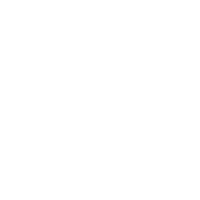

In [15]:
using SixLabors.ImageSharp.Processing;
using SixLabors.ImageSharp.Drawing.Processing;

// Parameters
int width = 200;
int height = 200;
int numberOfFrames = 11;
float frequency = 2.0f * (float)Math.PI / width;
float amplitude = 50;

// Create individual frames
var frames = new List<SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>>();

for (int t = 0; t < numberOfFrames; t++)
{
    var image = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);

    // Load a font for text drawing. For this example, I'll use a default system font.
    SixLabors.Fonts.FontCollection fontCollection = new SixLabors.Fonts.FontCollection();
    SixLabors.Fonts.FontFamily fontFamily = SixLabors.Fonts.SystemFonts.Families.FirstOrDefault();
    SixLabors.Fonts.Font font = fontFamily.CreateFont(18); // 18pt size

    image.Mutate(ctx => 
    {
        // make the background transparent
        ctx.Fill(SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#00000000"));

        SixLabors.ImageSharp.PointF[] points = new SixLabors.ImageSharp.PointF[width];
        for (int x = 0; x < width; x++)
        {
            int y = (int)(height / 2 + amplitude * Math.Sin(frequency * x + ((float)t/numberOfFrames) * 2.0f * Math.PI));
            points[x] = new SixLabors.ImageSharp.PointF(x, y);
        }
        ctx.DrawPolygon(SixLabors.ImageSharp.PixelFormats.Rgba32.ParseHex("#ff6347"), 2, points);

        // Draw the frame number
        ctx.DrawText(t.ToString(), font, SixLabors.ImageSharp.Color.White, new SixLabors.ImageSharp.PointF(width / 2, height / 2));
    });

    frames.Add(image);
    // save Image from stream to a file using png image encoder
    using (var fs = new System.IO.FileStream(System.IO.Path.Combine(System.IO.Path.GetDirectoryName(System.Reflection.Assembly.GetAssembly(typeof(ConsoleBenchmark.PlaywrightFixture)).Location) ?? throw new NullReferenceException(), $"{t}-" + NUlid.Ulid.NewUlid().ToString() + ConsoleBenchmark.FixtureConstants.ScreenshotType.Png), System.IO.FileMode.Create, System.IO.FileAccess.Write))
    {
        
        image.Save(fs, new SixLabors.ImageSharp.Formats.Png.PngEncoder());
    }
}

// Create the GIF
var outputImage = new SixLabors.ImageSharp.Image<SixLabors.ImageSharp.PixelFormats.Rgba32>(width, height);
for (int i = 0; i < frames.Count; i++)
{
    outputImage.Frames.AddFrame(frames[i].Frames.RootFrame);
    var frameMetadata = outputImage.Frames[i].Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance);
    frameMetadata.FrameDelay = 100;  // 100ms delay = 10fps
    frameMetadata.DisposalMethod = i == frames.Count-1 ? SixLabors.ImageSharp.Formats.Gif.GifDisposalMethod.NotDispose : SixLabors.ImageSharp.Formats.Gif.GifDisposalMethod.RestoreToBackground;
}

// Convert to base64 for inlining
using (var ms = new System.IO.MemoryStream())
{    
    outputImage.Metadata.GetFormatMetadata(SixLabors.ImageSharp.Formats.Gif.GifFormat.Instance).RepeatCount = 0;
    outputImage.Save(ms, new SixLabors.ImageSharp.Formats.Gif.GifEncoder());
    byte[] gifBytes = ms.ToArray();
    string base64Gif = Convert.ToBase64String(gifBytes);
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: $"data:image/gif;base64,{base64Gif}"]);
}

In [16]:
// vector 0
display("<script>alert('<script>alert(\'// vector 0\')</script>')</script>");
// vector 1
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "nonexistent.gif", onerror: "console.error('// vector 1'); alert('// vector 1');"]);
// vector 2
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script[value: "<script>alert('<script>alert(\'<script>alert(\'<script>alert(\'// vector 2\');console.error(\'// vector 2\');</script>\');</script>\');</script>');</script>"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script["alert('// vector 2');console.error('// vector 2');"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script["alert(\'// vector 2\');console.error(\'// vector 2\');"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script["<script>alert('<script>alert(\'<script>alert(\'<script>alert(\'// vector 2\');console.error(\'// vector 2\');</script>\');</script>\');</script>');</script>"]);
// vector 3
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.div[HTML("<svg onload='alert(\"// vector 3\");console.error(\"// vector 3\");'><rect width='100' height='100' style='fill:blue;'/></svg>")]);
// vector 4
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.a[href: "javascript:alert('// vector 4');", innerHTML: "vector 4"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.a[href: "javascript:console.error('// vector 4');", innerHTML: "vector 4"]);
// vector 5
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script[$"eval(atob('{Convert.ToBase64String(System.Text.Encoding.UTF8.GetBytes("alert('// vector 5');console.error('// vector 5');"))}'));"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.script[$"<script>eval(atob('{Convert.ToBase64String(System.Text.Encoding.UTF8.GetBytes("alert('// vector 5');console.error('// vector 5');"))}'));</script>"]);
// vector 6
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.button[onclick: "alert(\"alert('// vector 6');console.error('// vector 6');\");", innerHTML: "// vector 6"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.button[onclick: "alert(\"alert('// vector 6');console.error('// vector 6');\");", name: "vector 6"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.button[onclick: "alert(\"alert('// vector 6');console.error('// vector 6');\");", value: "vector 6"]);
// vector 7
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.div[HTML("<iframe src='javascript:alert(\"// vector 7\");'></iframe>")]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.div[HTML("<iframe src='javascript:console.error(\"// vector 7\");'></iframe>")]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "javascript:alert(\"// vector 7\");", width: 560, height: 315]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "javascript:console.error(\"// vector 7\");", width: 560, height: 315]);
// vector 8
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.input[type: "text", onfocus: "alert(\"alert('// vector 8');console.error('// vector 8');\");", autofocus: "true", placeholder: "// vector 8"]);
// vector 9
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "data:text/html;base64,PHNjcmlwdD5hbGVydCgnLy8gdmVjdG9yIDknKTtjb25zb2xlLmVycm9yKCcvLyB2ZWN0b3IgOScpOzwvc2NyaXB0Pgo="]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.iframe[src: "data:text/html;base64,PHNjcmlwdD5hbGVydCgnLy8gdmVjdG9yIDknKTtjb25zb2xlLmVycm9yKCcvLyB2ZWN0b3IgOScpOzwvc2NyaXB0Pg=="]);
// vector 10
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.div[style: "background-image: url('javascript:alert(\"// vector 10\")');"]);
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.div[style: "background-image: url('javascript:console.error(\"// vector 10\")');"]);
// vector 11
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/svg+xml;base64," + Convert.ToBase64String(System.Text.Encoding.UTF8.GetBytes("<svg onload='alert(\"// vector 11\");console.error(\"// vector 11\");'><rect width='100' height='100' style='fill:blue;'/></svg>"))]);
// vector 12
display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/svg+xml;base64," + Convert.ToBase64String(System.Text.Encoding.UTF8.GetBytes("<svg xmlns='http://www.w3.org/2000/svg' onload='alert(\"// vector 12\");console.error(\"// vector 12\");'><rect width='100' height='100' style='fill:blue;'/></svg>"))]);



<script>alert('<script>alert('// vector 0')</script>')</script>

'); '); '); >

>